# A Quick Start

## Import Libraries

In [ ]:
#### IMPORT LIBRARY ####
import scanpy as sc
import imap
import numpy as np

## Loading and preprocessing data 

The first line reads in the <a href='https://cloud.tsinghua.edu.cn/f/c607c601a7fc4c66af4e/?dl=1'>DC_complete</a> dataset, and the following lines preprocesses the DC data. The DC dataset contains only two sub-datasets, around 760 cells. This small dataset is used as a quickstart.

Since iMAP needs input in the form of log-TPM, it is necessary to preprocess the original data. For convenience, Scanpy API `scanpy.pp.highly_variable_genes(flavor='seurat_v3')` is used in iMAP to provide a preprocessing function for users.

Parameter `key`: Name of annotation of batch information in adata. Set to `'batch'` here.

In [ ]:
adata = sc.read_loom('../data/DC_complete.loom', sparse=False)
# `scanpy.pp.highly_variable_genes` with `flavor='seurat_v3'` expects raw count data.
adata.X = np.float32(np.int32(adata.X))
adata = imap.stage1.data_preprocess(adata, key='batch')

## Batch effect removal by iMAP

DC_complete dataset only contains around 760 cells. The number of sampled cells is far less than 3000(default number of samples used in iMAP), while the amount of minibatch is fixed. Excessive training epochs will lead to overfitting. Therefore, for datasets with a small number of cells, training epochs can be reduced according to the actual situation. Due to the small number of cells, k1 and k2 calculated by default parameters are 1 and 3, respectively. As a result, the number of rwMNN pairs selected is small and the sample distribution cannot be well covered. Therefore, the value of k2 is appropriately increased to 5 here.

See the "Cell Line Tutorial" for more detailed instructions.

In [ ]:
EC, ec_data = imap.stage1.iMAP_fast(adata, key="batch", n_epochs=50)
output_results = imap.stage2.integrate_data(adata, ec_data, n_epochs=40, k1=1, k2=5)

## iMAP Results

In [ ]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap

In [ ]:
#### UMAP ####
def data2umap(data, n_pca=0):
    if n_pca > 0:
        pca = PCA(n_components=n_pca)
        embedding = pca.fit_transform(data)
    else:
        embedding = data
    embedding_ = umap.UMAP(
        n_neighbors=30,
        min_dist=0.3,
        metric='cosine',
        n_components = 2,
        learning_rate = 1.0,
        spread = 1.0,
        set_op_mix_ratio = 1.0,
        local_connectivity = 1,
        repulsion_strength = 1,
        negative_sample_rate = 5,
        angular_rp_forest = False,
        verbose = False
    ).fit_transform(embedding)
    return embedding_
def umap_plot(data, hue, title, save_path):
    import seaborn as sns
    fig = sns.lmplot(
        x = 'UMAP_1',
        y = 'UMAP_2',
        data = data,
        fit_reg = False,
        legend = True,
        height = 9,
        hue = hue,
        scatter_kws = {'s':4, "alpha":0.6}
    )
#     plt.title(title, weight='bold').set_fontsize('20')
#     fig.savefig(save_path)
#     plt.close()

In [ ]:
#### General Plot ####
def gplot(embedding_, batch_info, celltype_info, filename):
    test = pd.DataFrame(embedding_, columns=['UMAP_1', 'UMAP_2'])
    test['Label1'] = batch_info
    test['Label2'] = celltype_info
    title = f'PIPELINE: G'
    for i in range(1,3):
        hue = f'Label{i}'
        save_path = './pic/'+filename + f'{i}.png'
        umap_plot(test, hue, title, save_path)

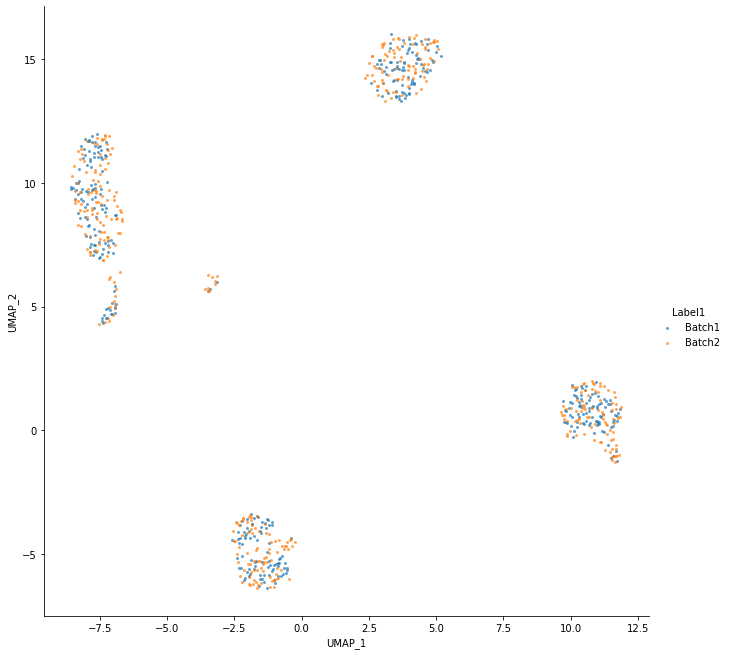

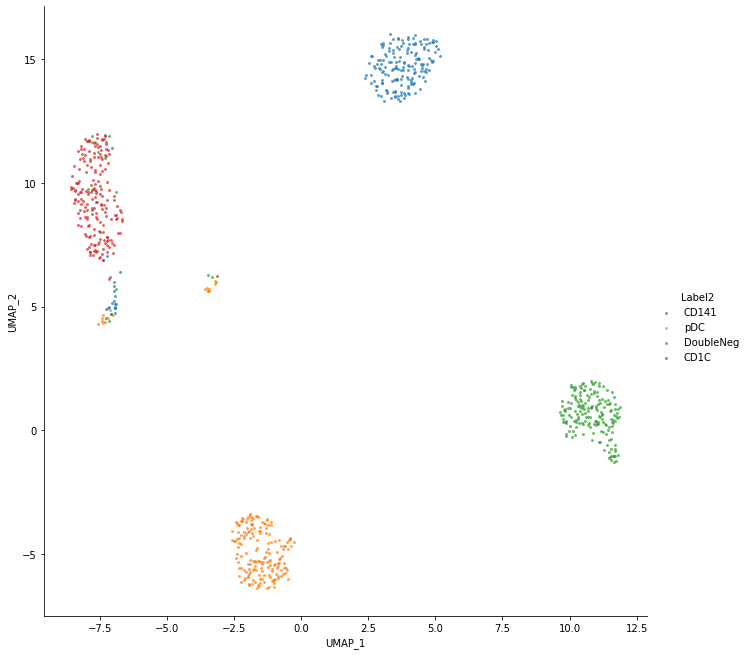

In [7]:
embedding_ = data2umap(output_results, n_pca=30)
gplot(embedding_, np.array(adata.obs['batch']), np.array(adata.obs['celltype']), 'dc_complete_G_')